Objectives
--
    0. Experimental / Model Data Availability
    1. Historical Data / Observations
    2. Standardized Anomaly Plots
    3. Find Rainfall Indices (Rnnmm, RXXp, CWD, CDD, PRCPTOT, 
    

In [7]:
import xarray as xr
import zipfile
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline

path = os.getcwd()

In [8]:
#unzip function
def unzip(z_file, model, print_info=True):
    with zipfile.ZipFile(z_file, 'r') as zip_ref:
        zip_ref.extractall(model)
        if print_info==True:
            print('Done with '+model+' model')
        
        
#standardization formula
def stand(x, dim):
    return (x-x.mean(dim))/x.std(dim)

In [9]:
def save_plot(path, filename):
    import matplotlib.pyplot as plt
    if os.path.isdir(path) == False:
        os.mkdir(path)
        
    plt.savefig(path+'/'+filename)

##################################################################################

############            MAIN CODE
--
##################################################################################


In [10]:
station = ['Talensi', 10.66, -0.72]

'''
#'cesm2_waccm_fv2','ec_earth3_cc','mpi_esm1_2_hr',

models = ['access_cm2','bcc_csm2_mr','cesm2_fv2','cmcc_cm2_hr4','cmcc_esm2','cnrm_cm6_1_hr',
'ec_earth3_aerchem','fgoals_f3_l','hadgem3_gc31_ll','iitm_esm','inm_cm5_0','ipsl_cm6a_lr','kiost_esm','miroc6',
'miroc_es2l','mri_esm2_0','norcpm1','noresm2_mm','taiesm1',
'access_esm1_5','awi_esm_1_1_lr','bcc_esm1','canesm5','cesm2','cesm2_waccm','cmcc_cm2_sr5',
'cnrm_cm6_1','cnrm_esm2_1','ec_earth3_veg_lr','fgoals_g3','gfdl_esm4','hadgem3_gc31_mm','inm_cm4_8',
'ipsl_cm5a2_inca','kace_1_0_g','mpi_esm1_2_lr','nesm3','sam0_unicon','ukesm1_0_ll']

models = sorted(models)



#Hist, SSP[2.6, 4.5, 6.0, 8.5]    #(W/m^2) GHG Forcing
'''

models = ['access_cm2','bcc_csm2_mr','cesm2','cmcc_esm2','cnrm_cm6_1','cnrm_esm2_1','ec_earth3_veg_lr','fgoals_g3',
          'gfdl_esm4','hadgem3_gc31_ll','iitm_esm','inm_cm4_8','inm_cm5_0','ipsl_cm5a2_inca','ipsl_cm6a_lr','kace_1_0_g', 
          'miroc6','mpi_esm1_2_lr','miroc_es2l','mri_esm2_0','noresm2_mm','taiesm1','ukesm1_0_ll']
#'sam0_unicon',
models = sorted(models)

Visualization of Data
---

Standardized Anomaly Plots

Text(0.5, 0.98, '\n\nHISTORICAL')

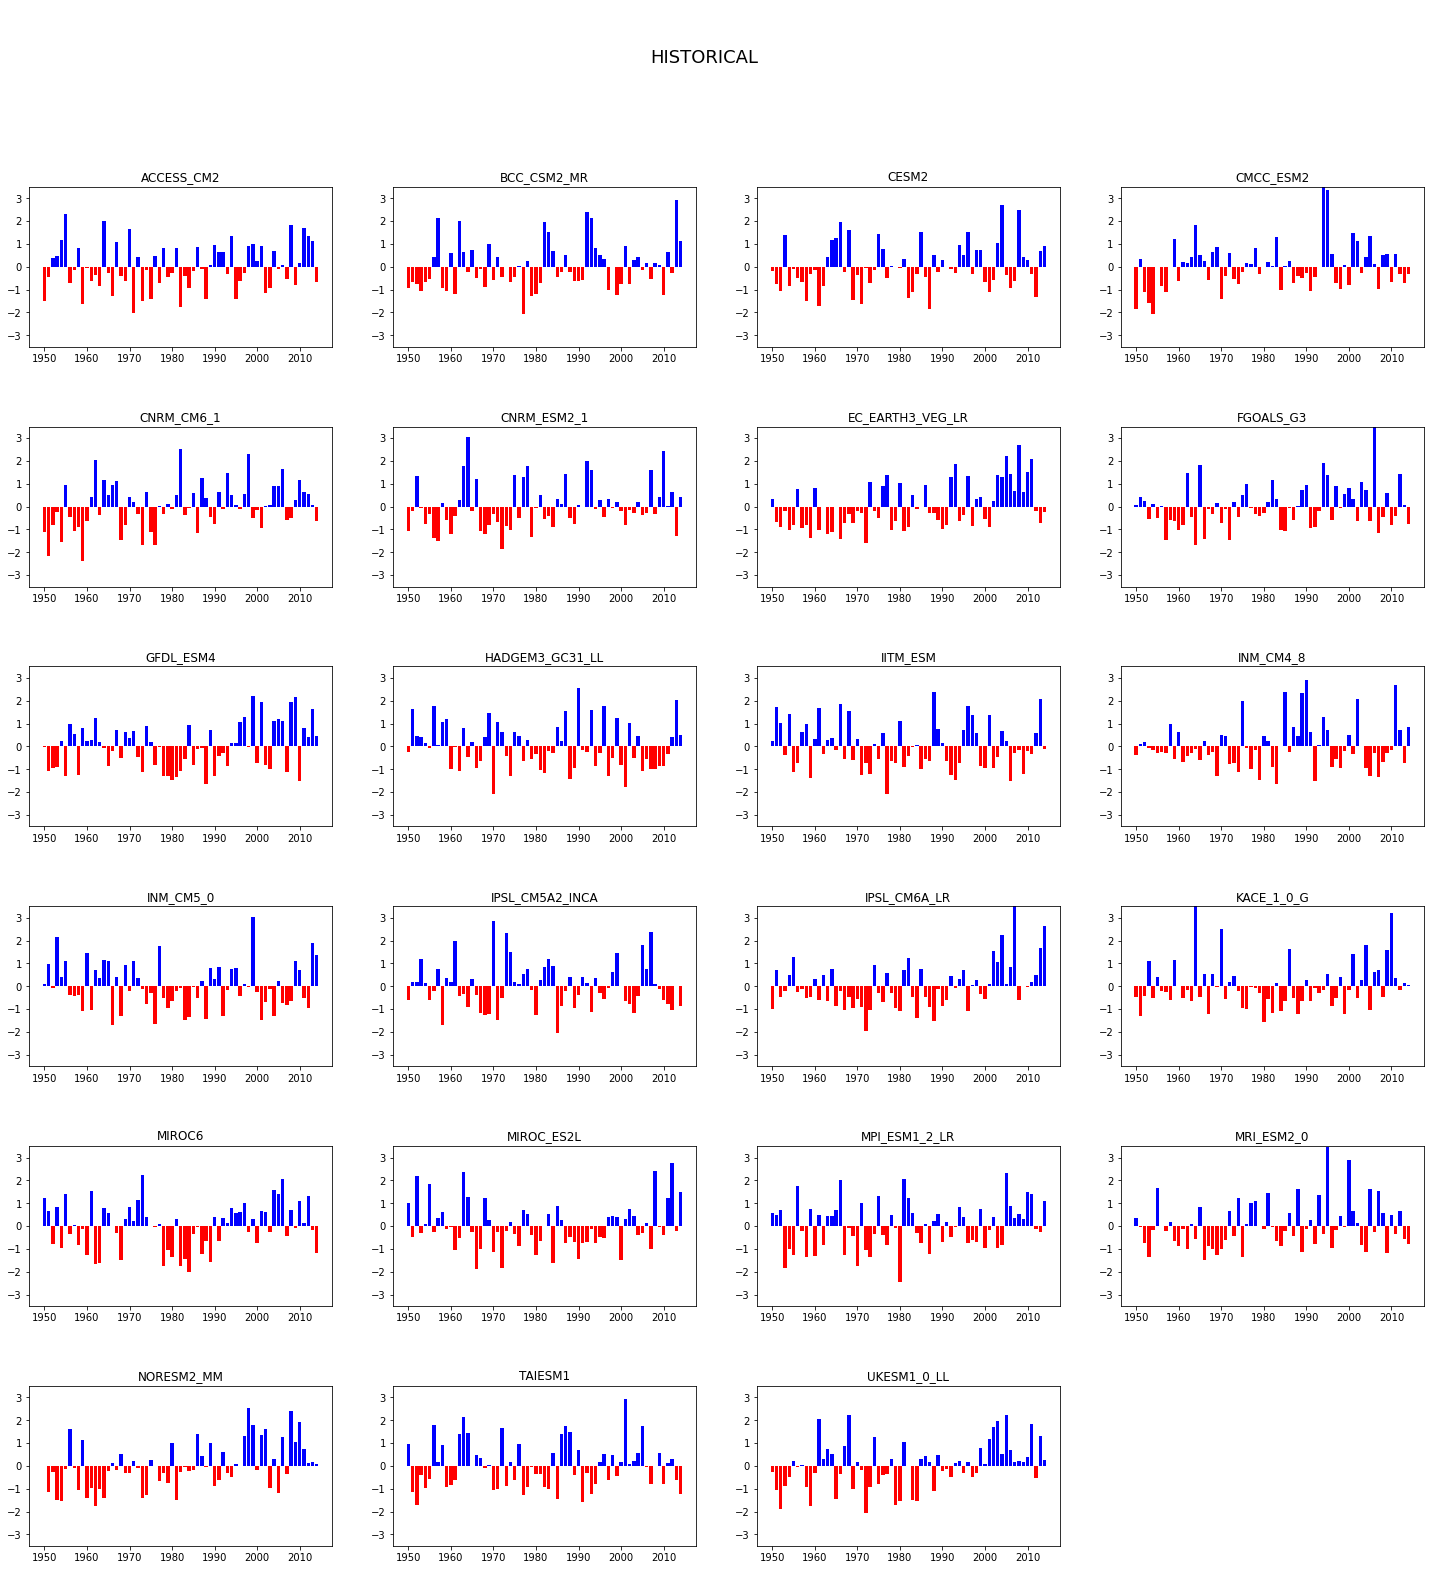

In [11]:
ystart=1950; yend=2014
exp='historical'
fig, axes = plt.subplots(ncols=len(models)//5, nrows=6, figsize=(25,25))
plt.subplots_adjust(hspace=0.5)
i = -1; plot_index=-1
for ax in axes:
    for rows in ax:
        i+=1; plot_index+=1
#Find Rainfall Indices (Rnnmm, RXXp, CWD, CDD, PRCPTOT, 
        try:
            file = glob.glob(os.path.join(path,exp+'/*'+models[i]+'*.zip'))[0]
            data_file = glob.glob(os.path.join(path,models[i]+'/pr*'+exp+'*.nc'))[0]
            
            if os.path.isfile(data_file) == False:
                unzip(file, models[i], print_info=True)
                
            da_data = xr.open_dataset(data_file)
            da_RR = da_data.pr.sel(lon=station[2], lat=station[1], method='nearest').sel(time=slice(str(ystart),str(yend))) * 86400   #convert rainfall from kg m-2 s-1 to mm/day
            
            
            a = da_RR.resample(time='1Y').sum('time')
            col_scheme = np.where(stand(a, 'time').values>0, 'b','r')
            rows.bar(a['time.year'], stand(a, 'time').values, color=col_scheme)#, ax=rows)
            #stand(a, 'time').plot(color='k', ax=rows)   #rolling(time=)
            #plot()
            rows.set_ylim(-3.5,3.5)
            #print(i, data_file)
            rows.set_title(models[i].upper(), fontsize=12)
            
            if i>=len(models):
                rows.set_visible(False)



        except:
            plot_index-=1
            if i>=len(models):
                rows.set_visible(False)
            pass
plt.suptitle('\n\n'+exp.upper(), fontsize=18)

#plot_dir = os.path.join(os.getcwd()+'/Figures')
#save_plot(plot_dir, exp+'_few.png')

Joint Line Plot plus Ensemble Mean
--

Text(0.5, 0, 'Year')

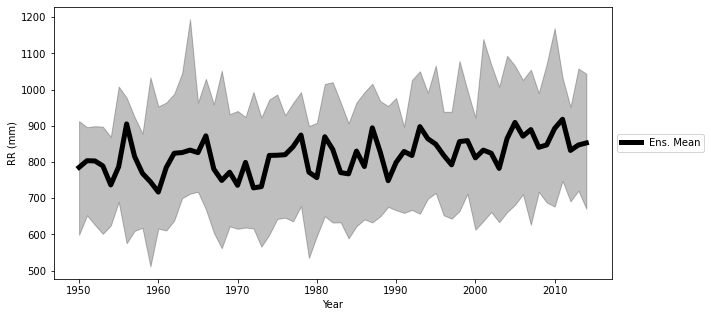

In [29]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
import random
#colors = [random.choice(color) for i in range(10)]
colors=['r','g','b','m','c','k','brown','y','gray','purple','orange','#225ea8']
ls = ['-','--']
#ystart=1850; yend=2020
out_25=np.ones((len(models), (yend-ystart)+1))*np.nan
out=np.ones((len(models), (yend-ystart)+1))*np.nan
out_75=np.ones((len(models), (yend-ystart)+1))*np.nan
for i, model in enumerate(sorted(models)):
    
    try:
        file = glob.glob(os.path.join(path,exp+'/*'+model+'*.zip'))[0]
        data_file = glob.glob(os.path.join(path,model+'/pr*'+exp+'*.nc'))[0]

        if os.path.isfile(data_file) == False:
            unzip(file, model, print_info=True)

        da_data = xr.open_dataset(data_file)
        da_RR = da_data.pr.sel(lon=station[2], lat=station[1], method='nearest').sel(time=slice(str(ystart),str(yend))) * 86400   #convert rainfall from kg m-2 s-1 to mm/day

        da_RR_Yr = da_RR.resample(time="Y").sum('time')
        #da_RR_std = stand(da_RR_Yr, dim='time')
        da_RR_std = da_RR_Yr
        
        #output.append(da_RR_std.mean(['lat','lon']).values)
        out[i,:da_RR_std['time.year'].size] = da_RR_std.values
        #out_25[i,:da_RR_std['time.year'].size] = da_RR_std.reduce(np.nanpercentile, dim=['lat','lon'], q=25).values
        #out_75[i,:da_RR_std['time.year'].size] = da_RR_std.reduce(np.nanpercentile, dim=['lat','lon'], q=75).values
        
        da_std_fin = da_RR_std#.rolling(time=5, center=True).mean('time')
        #plt.plot(da_std_fin.time, da_std_fin, linestyle=ls[i//len(colors)], color=colors[i%len(colors)], label=model)
    except:
        pass

    
out = np.copy(out)
plt.plot(np.arange(ystart,yend+1), np.nanmedian(out, axis=0)[0:len(da_std_fin.time)], color='k', linewidth=5, label='Ens. Mean')
plt.fill_between(np.arange(ystart,yend+1), y1=np.nanpercentile(out, 25, axis=0), y2=np.nanpercentile(out, 75, axis=0), color='k', alpha=0.25)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.ylabel('RR (mm)')
plt.xlabel('Year')

#plot_dir = os.path.join(os.getcwd()+'/Figures')
#save_plot(plot_dir, 'ensembles_timeseries.png')

Text(0.5, 0, 'Year')

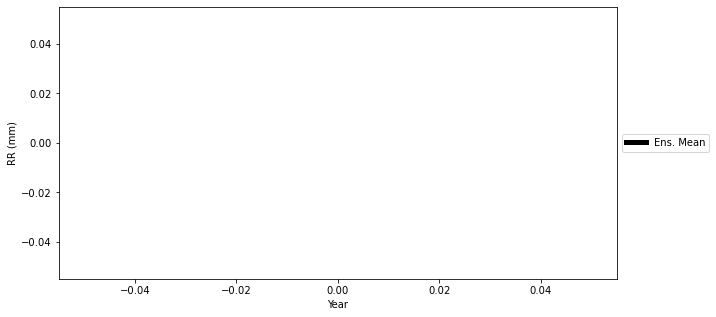

In [32]:
fig = plt.figure(figsize=(10,5))
exp='ssp3_7_0'

ax = plt.subplot(111)
import random
#colors = [random.choice(color) for i in range(10)]
colors=['r','g','b','m','c','k','brown','y','gray','purple','orange','#225ea8']
ls = ['-','--']
#ystart=1850; yend=2020
out_25=np.ones((len(models), (yend-ystart)+1))*np.nan
out=np.ones((len(models), (yend-ystart)+1))*np.nan
out_75=np.ones((len(models), (yend-ystart)+1))*np.nan
for i, model in enumerate(sorted(models)):
    
    try:
        
        file = glob.glob(os.path.join(path,exp+'/*'+model+'*.zip'))[0]
        data_file = glob.glob(os.path.join(path,model+'/pr*'+exp+'*.nc'))[0]

        if os.path.isfile(data_file) == False:
            unzip(file, model, print_info=True)

        da_data = xr.open_dataset(data_file)
        da_RR = da_data.pr.sel(lon=station[2], lat=station[1], method='nearest').sel(time=slice(str(ystart),str(yend))) * 86400   #convert rainfall from kg m-2 s-1 to mm/day

        da_RR_Yr = da_RR.resample(time="Y").sum('time')
        #da_RR_std = stand(da_RR_Yr, dim='time')
        da_RR_std = da_RR_Yr
        
        #output.append(da_RR_std.mean(['lat','lon']).values)
        out[i,:da_RR_std['time.year'].size] = da_RR_std.values
        #out_25[i,:da_RR_std['time.year'].size] = da_RR_std.reduce(np.nanpercentile, dim=['lat','lon'], q=25).values
        #out_75[i,:da_RR_std['time.year'].size] = da_RR_std.reduce(np.nanpercentile, dim=['lat','lon'], q=75).values
        
        da_std_fin = da_RR_std#.rolling(time=5, center=True).mean('time')
        #plt.plot(da_std_fin.time, da_std_fin, linestyle=ls[i//len(colors)], color=colors[i%len(colors)], label=model)
    except:
        pass

    
out = np.copy(out)
plt.plot(np.arange(ystart,yend+1), np.nanmedian(out, axis=0)[0:len(da_std_fin.time)], color='k', linewidth=5, label='Ens. Mean')
plt.fill_between(np.arange(ystart,yend+1), y1=np.nanpercentile(out, 25, axis=0), y2=np.nanpercentile(out, 75, axis=0), color='k', alpha=0.25)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.ylabel('RR (mm)')
plt.xlabel('Year')

#plot_dir = os.path.join(os.getcwd()+'/Figures')
#save_plot(plot_dir, 'ensembles_timeseries.png')

Climate / Rainfall Metrics
--

- Rnnmm

In [30]:
def Rnnmm(data, thresh, dim):
    da_count = data.where(data>thresh).groupby('time.year')
    return(da_count, da_count.count(dim))



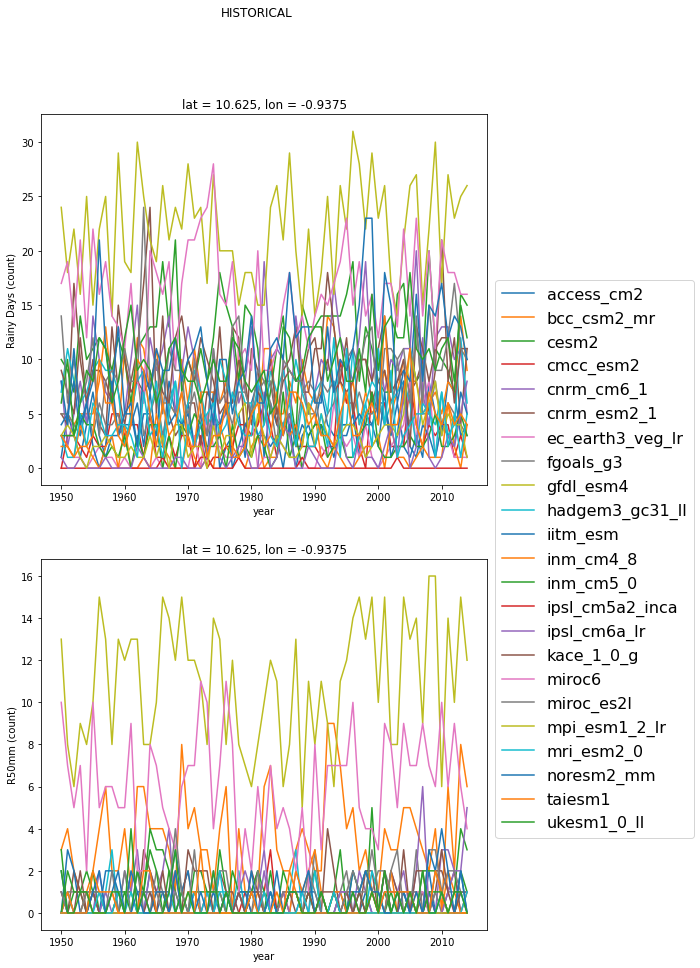

In [31]:
exp = 'historical'
thresholds = [20, 50]  #[1,10,20,30]
#ystart=1850; yend=2014

fig, axes = plt.subplots(nrows=len(thresholds), figsize=(8,15))
for ind, ax in enumerate(axes):
    output = np.ones((len(models), (yend-ystart)+1))*np.nan

    for model in sorted(models):
        try:
            file = glob.glob(os.path.join(path,exp+'/*'+model+'*.zip'))[0]
            data_file = glob.glob(os.path.join(path,model+'/pr*'+exp+'*.nc'))[0]

            if os.path.isfile(data_file) == False:
                unzip(file, model, print_info=True)

            da_data = xr.open_dataset(data_file)
            da_RR = da_data.pr.sel(lon=station[2], lat=station[1], method='nearest').sel(time=slice(str(ystart),str(yend))) * 86400   #convert rainfall from kg m-2 s-1 to mm/day
                
            a_yr_tot = Rnnmm(da_RR, thresholds[ind], dim='time')[1]
            # = a.mean(['lon','lat'])
            
            #print('Here')
            #output[ind,:a['year'].size] = a_yr_tot.values
       
            a_yr_tot.plot(label=model, ax = ax)
            

        except:
            pass


    #output = np.copy(output)
    #ax.plot(a_yr_tot.year, np.nanmean(output, axis=0)[0:len(a_yr_tot.year)], color='k', linewidth=2.5, label='Ens. Mean')

    if ind == 0:
        ax.set_ylabel('Rainy Days (count)')
    else:
        ax.set_ylabel('R'+str(thresholds[ind])+'mm (count)')
    plt.suptitle(exp.upper())
axes[-1].legend(loc='center left', bbox_to_anchor=(1, 1), ncol=1, fontsize=16)

In [21]:
a_yr_tot

<xarray.DataArray 'pr' (year: 165)>
array([0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 3, 0, 2, 0,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 1, 2,
       0, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0,
       0, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 3, 2, 4, 2, 0, 2, 0])
Coordinates:
    lat      float64 10.84
    lon      float64 -1.25
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014

Text(0.5, 0.98, 'SSP5_8_5')

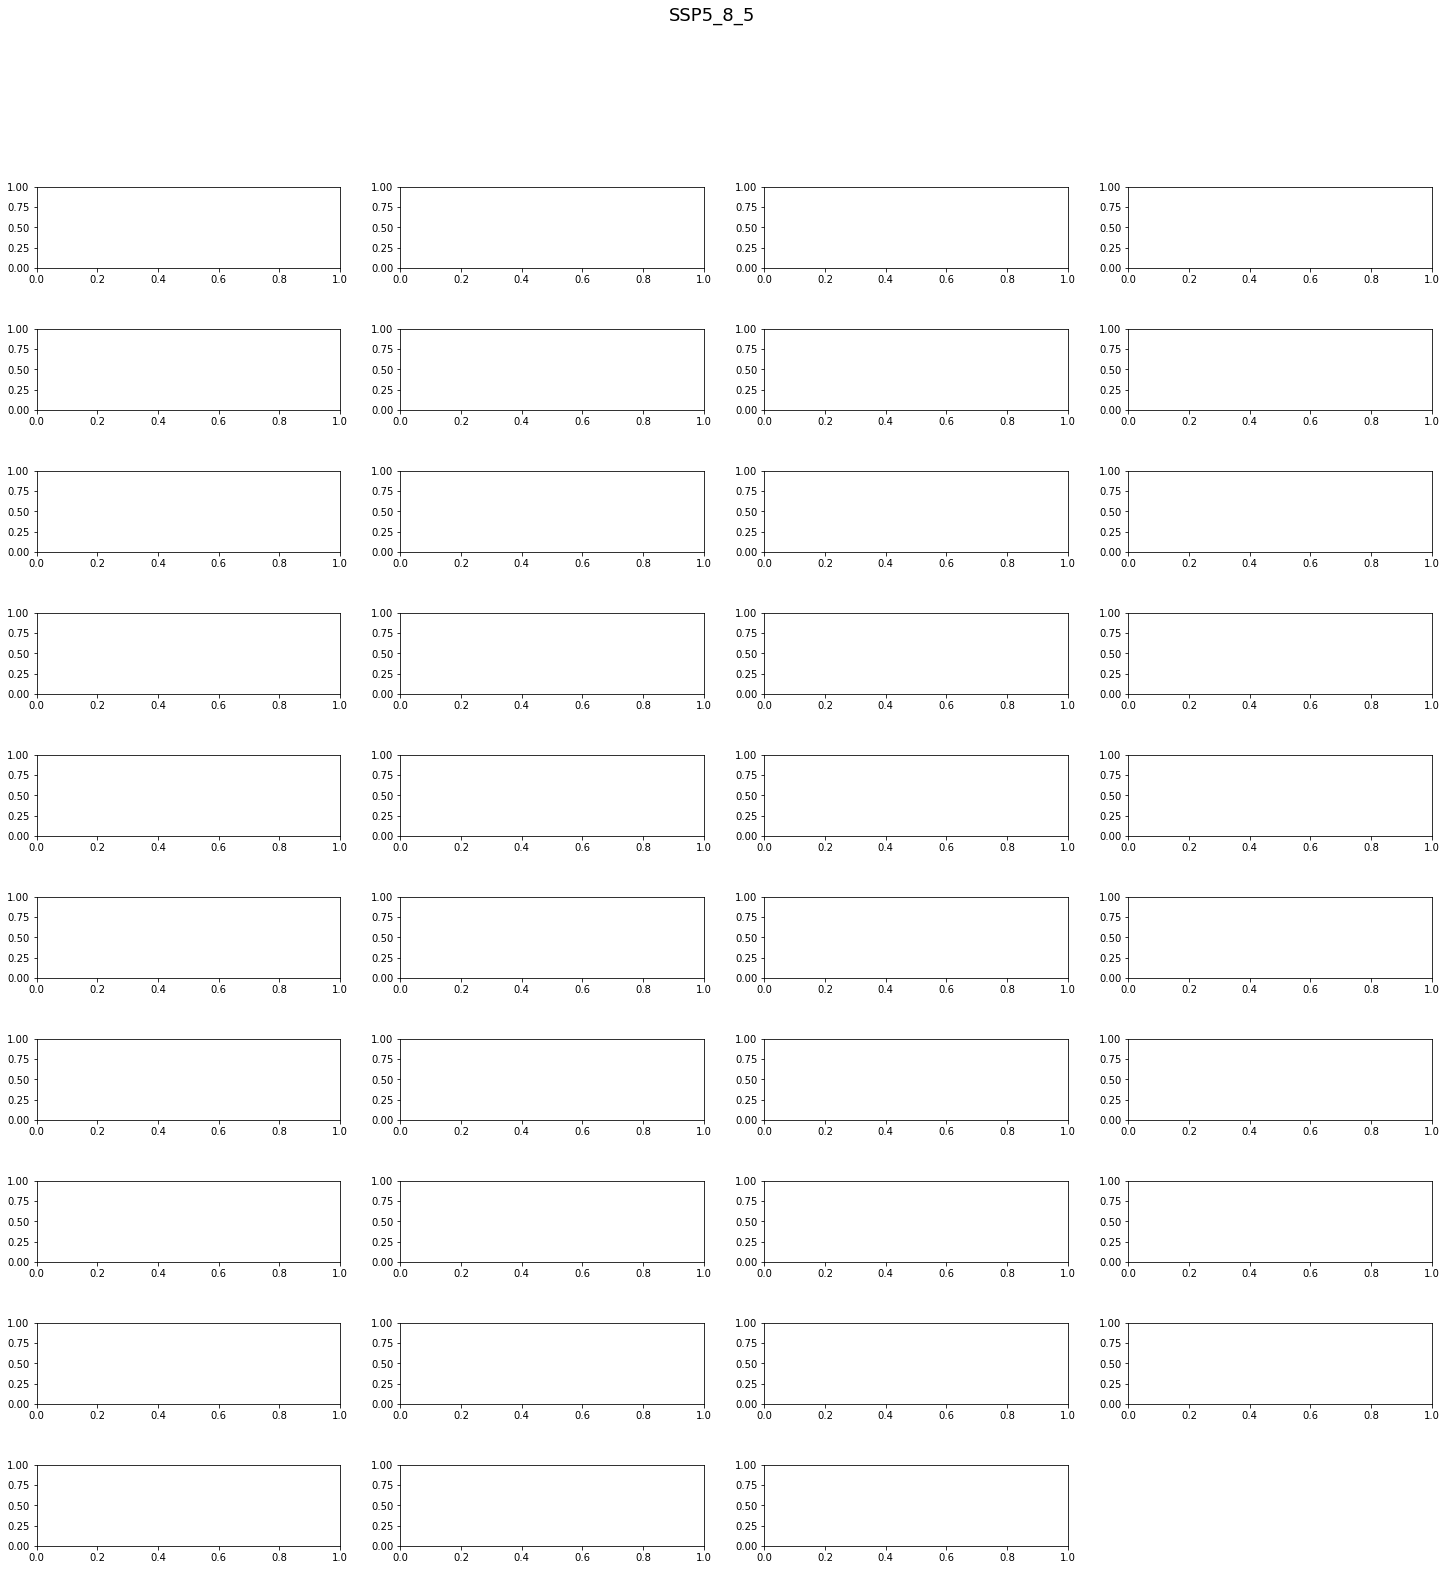

In [232]:
#exp='historical'
exp='ssp5_8_5'
fig, axes = plt.subplots(ncols=len(models)//9, nrows=10, figsize=(25,25))
plt.subplots_adjust(hspace=0.75)
i = -1; plot_index=-1
for ax in axes:
    for rows in ax:
        i+=1; plot_index+=1

        try:
            file = glob.glob(os.path.join(path,exp+'/*'+models[i]+'*.zip'))[0]
            data_file = glob.glob(os.path.join(path,models[i]+'/pr*'+exp+'*.nc'))[0]
            
            if os.path.isfile(data_file) == False:
                unzip(file, models[i], print_info=True)
                
            da_data = xr.open_dataset(data_file)
            da_RR = da_data.pr * 86400   #convert rainfall from kg m-2 s-1 to mm/day
            
            #a = Rnnmm(da_RR, 10, dim='time')[1]
            #a = a.median(['lon','lat'])
            #a.plot(ax = rows)
            #rows.bar(a['time.year'], stand(a, 'time').values, color=col_scheme)#, ax=rows)
            #stand(a, 'time').plot(color='k', ax=rows)   #rolling(time=)
            #plot()
            #rows.set_ylim(-3,3)
            #print(i, data_file)
            #rows.set_title(models[i].upper(), fontsize=12)
            
            #if i>=len(models):
            #    rows.set_visible(False)



        except:
            plot_index-=1
            if i>=len(models):
                rows.set_visible(False)
            pass
plt.suptitle(exp.upper(), fontsize=18)